In [1]:
# -- IMPORTS -- #
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from scipy.ndimage.filters import gaussian_filter, median_filter
from keras.preprocessing import image as kerasImage
from keras.layers import Dense
from keras.models import Model
from keras.activations import relu
from tensorflow.python.framework import ops
from PIL import Image as pilImage
from os import listdir
from os.path import isfile, join
import keras.backend as K
import os
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [19]:
# -- DEFINE FUNCTIONS -- #
def load_image(path,targetSize=(224,224),preprocess=True):
    data = kerasImage.load_img(path,target_size=targetSize)
    if preprocess:
        data = kerasImage.img_to_array(data)
        data = np.expand_dims(data,axis=0)
        data = preprocess_input(data)
    return data

def normalize(x):
    return (x+K.epsilon())/(K.sqrt(K.mean(K.square(x)))+K.epsilon())

def deprocess_image(x):
    x = x.copy()
    x -= x.mean(); x /= (x.std() + K.epsilon()); x *= 0.1
    # CLIP DATA
    x += 0.5; x = np.clip(x, 0, 1)
    # CONVERT TO RGB
    x *= 255; x = np.clip(x, 0, 255).astype('uint8')
    return x

def configure_guided_backpropagation(model):
    if 'GuidedBackProp' not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * tf.cast(op.inputs[0] > 0., dtype)
    weights = model.layers[-1].get_weights()
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu':'GuidedBackProp'}):
        layerList = [layer for layer in model.layers[1:] if hasattr(layer, 'activation')]
        for layer in layerList:
            if layer.activation == relu:
                layer.activation = tf.nn.relu
        # -- RECALL THE MODEL -- #
        model1 = VGG16(weights='imagenet',include_top=True)
        model1.layers.pop()
        model1.layers[-1].outbound_nodes = []
        model1.outputs = [model1.layers[-1].output]
        output = Dense(1000,activation='relu',name='predictions')(model1.outputs[0])
        guidedModel = Model(inputs=model1.inputs,outputs=[output])
        guidedModel.layers[-1].set_weights(weights)
    return guidedModel

def guided_backpropagation(imgInput, guidedModel, activationLayer):
    modelInput = guidedModel.input
    layerOutput = guidedModel.get_layer(activationLayer).output
    argument = K.gradients(layerOutput,modelInput)[0]
    getGraph = K.function([modelInput],[argument])
    saliency = getGraph([imgInput])
    return saliency

def grad_cam(imgInput,gradModel,clSel,activationLayer,negGrad=False):
    clScore = gradModel.output[0, clSel]
    convOutput = gradModel.get_layer(activationLayer).output
    grads = K.gradients(clScore, convOutput)[0]
    if negGrad:
        print('Negative Explanation')
        grads = -grads
    getGraph = K.function([gradModel.input],[convOutput, grads])
    # -- GET OUTPUT AND WEIGHTS -- #
    output, gradsVal = getGraph([imgInput])
    output, gradsVal = output[0, :], gradsVal[0, :, :, :]
    # -- OBTAIN HEATMAP -- #
    weights = np.mean(gradsVal,axis=(0,1))
    cam = np.dot(output,weights)

    # -- PREPROCESS HEATMAP -- #
    cam = np.asarray(pilImage.fromarray(cam).resize((224,224),pilImage.BILINEAR),dtype='float32')
    cam = np.maximum(cam, K.epsilon())
    cam = cam/cam.max()
    return cam

In [20]:
# -- CREATE DIRECTORY -- #
if not os.path.isdir('./Results/CAM'):
    os.mkdir('./Results/CAM')

# -- GET LIST OF IMAGES -- #
#reservedFiles = ['.DS_Store']
#dataDirectory = './Data/images/'
#imgTest = []
#for im in listdir(dataDirectory):
#    if isfile(join(dataDirectory, im)) and im not in reservedFiles:
#        imgTest.append(join(dataDirectory,im))  

# -- BUILD MODELS -- #
model = VGG16(weights='imagenet',include_top=True)
guidedModel = configure_guided_backpropagation(model)

In [45]:
# -- USER PRIORITIES -- #
topCls = 5
imgSel = input('Select the image')
fileName = './Data/images/'+imgSel+'.jpg'
pred = model.predict(load_image(fileName))
print(np.argsort(pred)[0][-topCls:][::-1])
print(decode_predictions(pred,top=topCls)[0])
clSel = int(input('Select the class to explain (0-{0})'.format(model.outputs[0].get_shape()[1]-1)))
#imgSel = int(input('Select an image. From (0-{0})'.format(len(imgTest)-1)))
for layer in guidedModel.layers:
    if hasattr(layer, 'activation'):
    #if layer.__class__.__name__ == 'Conv2D':
        print(layer.name)
#layerSel = input('Select the activation Layer:')
layerSel = 'block5_conv3'

Select the image test_81


[895 908 405 404 744]
[('n04552348', 'warplane', 0.98316824), ('n04592741', 'wing', 0.0116920015), ('n02692877', 'airship', 0.0012620836), ('n02690373', 'airliner', 0.0012445163), ('n04008634', 'projectile', 0.0011951264)]


Select the class to explain (0-999) 403


block1_conv1
block1_conv2
block2_conv1
block2_conv2
block3_conv1
block3_conv2
block3_conv3
block4_conv1
block4_conv2
block4_conv3
block5_conv1
block5_conv2
block5_conv3
fc1
fc2
predictions


In [46]:
# -- GUIDED BACK PROPAGATION -- #
img = load_image(fileName)
prediction = model.predict(img)
if clSel == -1:
    clSel = np.argmax(prediction)
top = decode_predictions(prediction, top=5)[0]
classes = np.argsort(prediction[0])[-5:][::-1]
print('Model prediction:')
for c, p in zip(classes, top):
    print('\t{:15s}\t({})\twith probability {:.3f}'.format(p[1], c, p[2]))
    
# -- GET SALIENCE MAP -- #
neg = False
negSel = '_1' if neg else ''
cam = grad_cam(img,model,clSel,layerSel,negGrad=neg)
threshCAM = np.mean(cam)*0.8
gcam = cam.copy()
gcam[gcam<threshCAM] = 0.0
saliency = guided_backpropagation(img,guidedModel,layerSel)
salImage = deprocess_image(saliency[0][0,:,:,:].copy())
guidedCAM = saliency[0][0,:,:,:]*gcam[...,np.newaxis]

Model prediction:
	warplane       	(895)	with probability 0.983
	wing           	(908)	with probability 0.012
	airship        	(405)	with probability 0.001
	airliner       	(404)	with probability 0.001
	projectile     	(744)	with probability 0.001


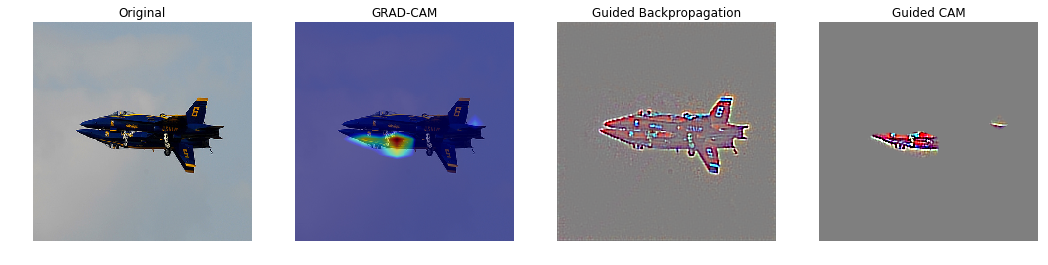

In [47]:
# -- BUILD FIGURE AND SAVE IT -- #
fig = plt.figure(figsize=(18,14))
plt.subplot(141)
plt.title('Original')
plt.axis('off')
plt.imshow(load_image(fileName,preprocess=False))
plt.subplot(142)
plt.title('GRAD-CAM')
plt.axis('off')
plt.imshow(load_image(fileName,preprocess=False))
plt.imshow(cam,cmap='jet',alpha=0.5)
plt.subplot(143)
plt.title('Guided Backpropagation')
plt.axis('off')
plt.imshow(salImage)
plt.subplot(144)
plt.title('Guided CAM')
plt.axis('off')
plt.imshow(deprocess_image(guidedCAM.copy()))
plt.show()
fig.savefig('./Results/CAM/'+str(clSel)+'_'+layerSel+'_'+imgSel+negSel+'.png',dpi=250)